# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2: Debiasing data and fairer models

### Group random:
 * Constantin-Bogdan Craciun (cocr@itu.dk)
 * Gino Franco Fazzi (gifa@itu.dk)
 * Veron Hoxha (veho@itu.dk)

#### Imports

In [31]:
# Folktables library
from folktables import ACSDataSource, BasicProblem, generate_categories
# Arrays and dataframes libraries
import numpy as np
import pandas as pd
# Statistical and algebra library
import scipy
from scipy.stats import  pearsonr
# ML libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Functions

In [40]:
def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


def evaluate_model(estimator, X, y, groups, cv = 5, random_state = 7):
    '''
    Function to evaluate a given estimator using Cross-Validation.
    Arguments: 
     - estimator: sklearn estimator to use. Must contain a fit and predict method.
     - X: data features
     - y: data labels
     - groups: dictionary indicating the group partition
     - cv: how many k folds splits. Default: 5
     - random_state: random seed for the splits
    '''

    # Let's record all fold's results
    cv_results = {}

    # Create an instance of CV splitter
    kf = KFold(n_splits=cv, random_state=random_state, shuffle=True)

    # For each K fold, fit the model and calculate the metrics
    for k, (train_index, test_index) in enumerate(kf.split(X)):

        # Fit model to the specific K split data
        estimator.fit(X[train_index], y[train_index])
        # Predict on the K split test data
        y_hat = estimator.predict(X[test_index])

        # Calculate Scores for each group
        for group, group_idxs in groups.items():

            # Retrieve group ids
            group_id = group_idxs.iloc[test_index]

            # If group is not in results, add it
            if group not in cv_results:
                cv_results[group] = {"f1": [], "accuracy": [], "pos_rate": []}
            
            # Append the k's f1, accuracy and TPR for the given group
            cv_results[group]["f1"].append(f1_score(y[test_index][group_id], y_hat[group_id]))
            cv_results[group]["accuracy"].append(accuracy_score(y[test_index][group_id], y_hat[group_id]))
            cv_results[group]["pos_rate"].append(np.mean(y_hat[group_id]))

    
    # Aggregate CVs
    for group in groups:

        for metric in ["f1", "accuracy", "pos_rate"]:
            avg = np.mean(cv_results[group][metric])
            std = np.std(cv_results[group][metric])
            cv_results[group][f"{metric}_avg"] = avg
            cv_results[group][f"{metric}_std"] = std
            del cv_results[group][metric]

    return pd.DataFrame(cv_results).T


def debias_features(Xs_np, Xs_p, lambda_ = 1):
    """
    Function that applies the proposed geometric method to removes correlations between data and any number of protected variables.
    by He et al. (https://doi.org/10.1145/3375627.3375864)

    """
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p) #px

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np # rj

    # Return debiased nonprotected features
    return Xs_np_debiased + lambda_ * (Xs_np - Xs_np_debiased)


def evaluate_lambda(model, X_train_np, X_train_p, y_train, protected_feat_dict, lambda_range = [0, 1], load_computations = True):
    """
    Function to evaluate the effect of different lambdas in debiasiang of a dataset using the geometric method proposed by He et al. (https://doi.org/10.1145/3375627.3375864)
    Arguments:
     - model: The sklearn estimator to evaluate
     - X_train_np: The non-protected features
     - X_train_p: The protected features
     - y_train: The true labels for training
     - protected_feat_dict: Dictionary of protected features in the form <i: feat>, where i is in the index of the feature in X_p and feat is the feature string denomation.
    """
    # Collect the metrics of interest
    results = {"lambda": [], "accuracy": [], "f1": []}
    results.update({f"corr_{f}": [] for f in protected_feat_dict.values()})

    # Apply the different lambdas to the geometric method
    for l in np.linspace(lambda_range[0], lambda_range[1], 11):
        # If we have saved the computed debiased features, load them
        if load_computations:
            try:
                print(f"Attempting to retrieve load computations for lambda {l:.1f}...")
                Xs_train_np_debiased = np.load(f"./data/x_debiased_{l:.1f}.npy") # We have computed the debiased arrays in HPC and saved them for computing efficiency
            except:
                print(f"Computations not found. Trying to compute from scratch...")
                load_computations = False
        
        if not load_computations:
            try:
                Xs_train_np_debiased = debias_features(X_train_np, X_train_p, lambda_=l)
            except MemoryError: # Requires around 62 GB of memory, so it might fail
                print("Not sufficient memory to compute the geometrical debias method.")
            

        # Register the metrics for the given lambda
        results["lambda"].append(l)
        results["f1"].append(np.mean(cross_val_score(model, Xs_train_np_debiased, y=y_train, scoring="f1", cv=5, n_jobs=-1)))
        results["accuracy"].append(np.mean(cross_val_score(model, Xs_train_np_debiased, y=y_train, scoring="accuracy", cv=5, n_jobs=-1)))
        
        # Include the correlation metrics between features
        for i, feat in protected_feat_dict.items():
            results[f"corr_{feat}"].append(compute_correlation_weight(Xs_train_np_debiased, X_train_p[:, i].reshape(-1,1)))

    # Returns the results as a DataFrame
    return pd.DataFrame(results).fillna(0)


def compute_correlation_weight(X_np, X_p, alpha = 0.05):
    """
    Function to compute the correlation between a set of not protected and protected features.
    It uses a custom metric:
        The average of the absolute value of the Pearson's correlation between all pairs of Non-Protected vs Protected features.
        Only significant values are considered.
    """

    # Array of correlations    
    corrs = []

    # Compute Pearson correlation between each pair of Non-Protected - Protected features
    for i in range(X_np.shape[1]):
        for j in range(X_p.shape[1]):
            # Correlation of the non-protected feature i with protected feature j
            c, p = pearsonr(X_np[:,i], X_p[:,j])
            # If significant, append the absolute correlation value (to avoid cancelling out)
            if p < alpha:
                corrs.append(abs(c))

    # Return the average of the correlations
    return np.mean(corrs)

#### Data loading and preparation

In [3]:
# Seed for reproducibility
seed = 11012008

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

# Generate dictionary with indices to protected features
protect_dict = {}
j = 0
print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f):
        protect_dict[j] = "RACE"
        j += 1
        print("Column ID: %s" %i, "(%s)"%f)
    if ("SEX" in f):
        protect_dict[j] = "SEX"
        j += 1
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Pre-processing steps

We split the data to set aside a hold-out dataset to use only when reporting the final metrics for the models. Furthermore, we scale the features and dibide the dataset according to their features: protected and not protected.

In [4]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

# Boolean masks for different protected classes
group_dict = {"train": {}, "test": {}}
for k in group_dict:
    group_dict[k] = {
    'Males': eval(f"group_{k}")['SEX'] == 1,
    'Females': eval(f"group_{k}")['SEX'] == 2,
    'Whites': eval(f"group_{k}")['RAC1P'] == 1,
    'African-Americans': eval(f"group_{k}")['RAC1P'] == 2
}

# Scale all features (even OHE)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)
#n_features = X_train.shape[1]

# Subset for protected and non-protected features
Xs_train_p = Xs_train[:, 54:]
Xs_test_p = Xs_test[:, 54:]
Xs_train_np = Xs_train[:, :54]
Xs_test_np = Xs_test[:, :54]

## Selected Model: Logistic Regression with L2 regularization

In [5]:
model = LogisticRegression(penalty='l2', max_iter=1000)

# 1. Classification model trained on the raw dataset

We begin by training a simple Logistic regression binary classifier on the raw (potentially biased) dataset, and reporting key performance metrics, discrimanated by each protected attribute class: 
- Gender (men vs. women)
- Race (white vs. black)

### Evaluating the model using cross validation.

In [6]:
results = evaluate_model(model, Xs_train_np, y_train, groups = group_dict["train"], cv = 5, random_state = seed)

results

,f1_avg,f1_std,accuracy_avg,accuracy_std,pos_rate_avg,pos_rate_std
Males,0.893812,0.001544,0.840187,0.002014,0.768998,0.003264
Females,0.852496,0.003662,0.800923,0.004442,0.722467,0.003388
Whites,0.877512,0.001867,0.823787,0.002244,0.749275,0.002281
African-Americans,0.846723,0.005324,0.794183,0.007066,0.717866,0.008709


# 2. Classification model trained on the "fairer" versions of the dataset

Using He et al.'s geometric method that removes correlations between data and protected variables, we compute a “fairer” (reprojected) version of the dataset. We then use this dataset to train and evaluate a logistic regression classifier.

### First, we evaluate the debiasing method for various lambdas.

In [41]:
# Split the training dataset into train and validation sets for evaluating the lambdas
Xs_train_l_np, Xs_val_l_np, Xs_train_l_p, Xs_val_l_p, y_train_l, y_val_l = train_test_split(Xs_train_np, Xs_train_p, y_train.reshape(-1, 1),
                                                                                            test_size=0.3, random_state=0, shuffle=True)

lambda_results = evaluate_lambda(model = model, X_train_np = Xs_train_l_np, X_train_p = Xs_train_l_p, y_train = y_train_l, 
                protected_feat_dict = protect_dict, lambda_range = [0, 1])

lambda_results

Attempting to retrieve load computations for lambda 0.0...
Attempting to retrieve load computations for lambda 0.1...
Attempting to retrieve load computations for lambda 0.2...
Attempting to retrieve load computations for lambda 0.3...
Attempting to retrieve load computations for lambda 0.4...
Attempting to retrieve load computations for lambda 0.5...
Attempting to retrieve load computations for lambda 0.6...
Attempting to retrieve load computations for lambda 0.7...
Attempting to retrieve load computations for lambda 0.8...
Attempting to retrieve load computations for lambda 0.9...
Attempting to retrieve load computations for lambda 1.0...


,lambda,accuracy,f1,corr_SEX,corr_RACE
0,0.0,0.815531,0.871656,0.000000,0.000000
1,0.1,0.816209,0.872077,0.012367,0.008800
2,0.2,0.816839,0.872481,0.014227,0.012702
3,0.3,0.817563,0.872937,0.017484,0.014849
4,0.4,0.818004,0.873188,0.019673,0.015675
5,0.5,0.818823,0.873702,0.022839,0.018070
6,0.6,0.819548,0.874163,0.023548,0.020081
7,0.7,0.820257,0.874667,0.026384,0.021322
8,0.8,0.820682,0.874978,0.028455,0.023333
9,0.9,0.821344,0.875394,0.031407,0.025141


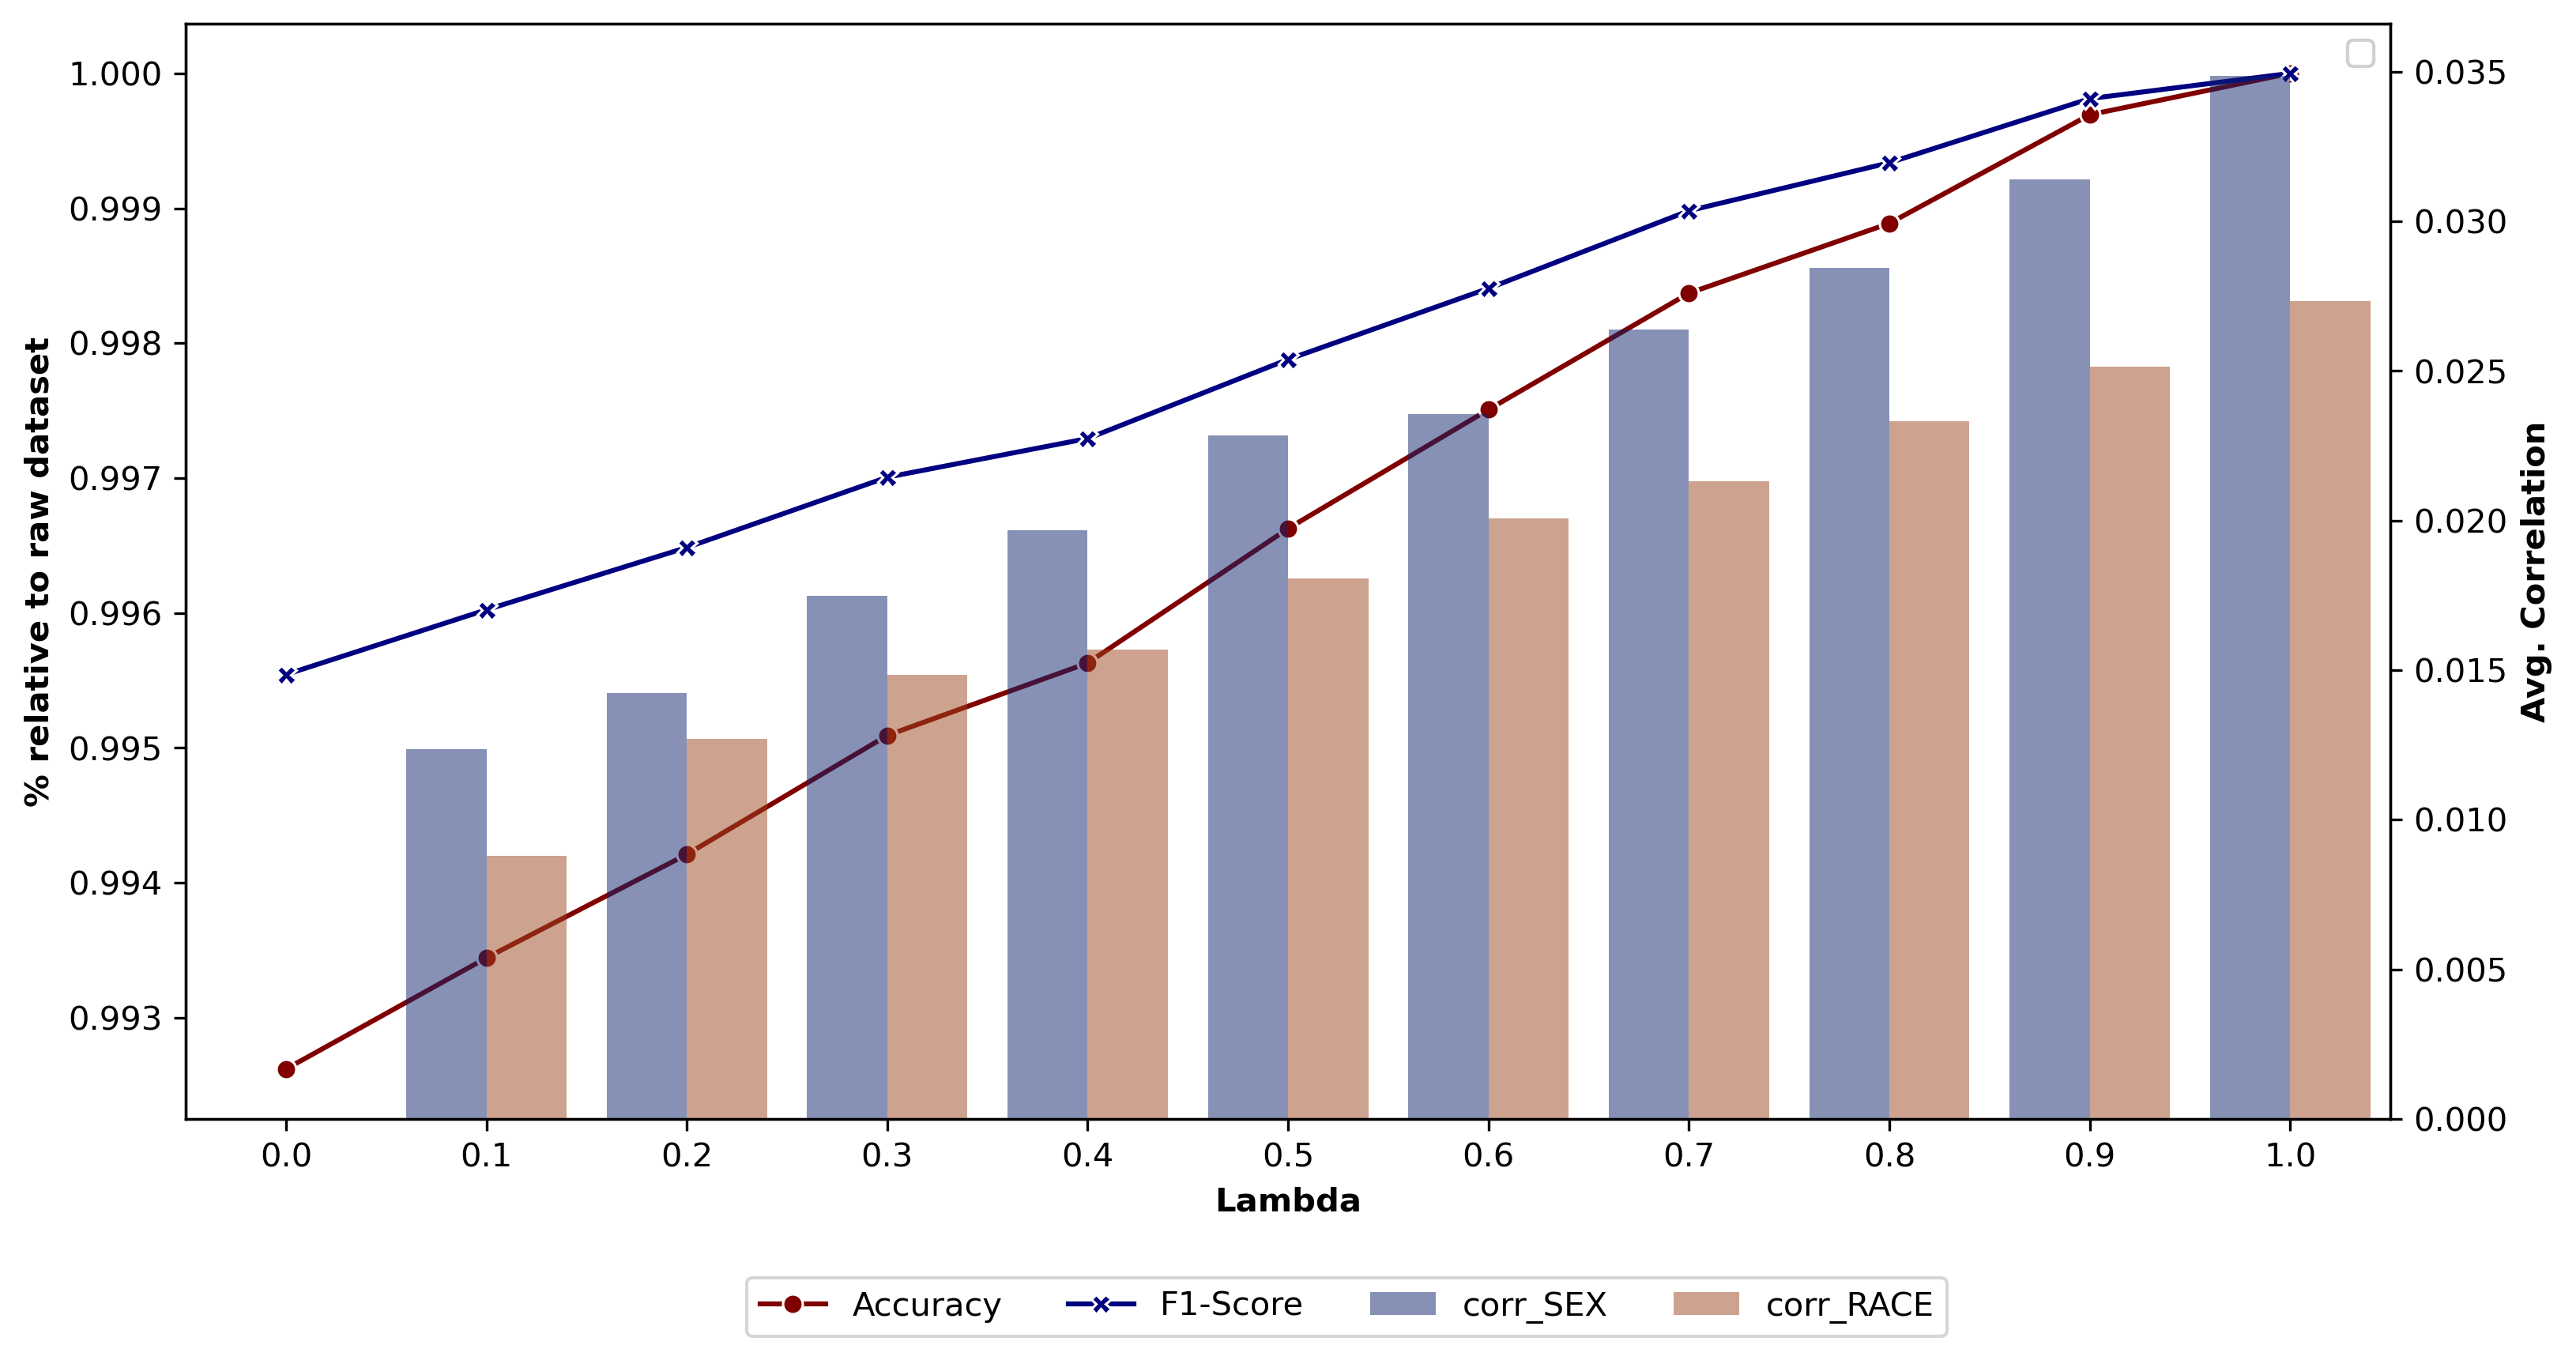

In [128]:
# Reshape the dataframe to plot
df = pd.melt(lambda_results, id_vars=['lambda', "accuracy", "f1"], value_vars=['corr_SEX', "corr_RACE"])
# Calculate the accuracy and f1 relative to the biased
acc = lambda_results["accuracy"] / lambda_results["accuracy"].max()
f1 = lambda_results["f1"] / lambda_results["f1"].max()

# Make a plot
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)

sns.lineplot(data = acc, marker='o', sort = False, ax=ax1, label="Accuracy", color="maroon")
sns.lineplot(data = f1, marker='X', sort = False, ax=ax1, label="F1-Score", color="navy")
ax2 = ax1.twinx()

sns.barplot(x = df['lambda'], y = df['value'], alpha=0.5, ax=ax2, hue=df["variable"], palette="dark")
ax2.set_xticklabels([f"{l:.1f}" for l in lambda_results["lambda"]])
ax1.set_xlabel("Lambda", weight="bold")
ax1.set_ylabel("% relative to raw dataset", weight="bold")
ax2.set_ylabel("Avg. Correlation", weight="bold")
ax1.legend("")
ax2.legend("")
fig.legend(ncol=4, bbox_to_anchor=(0.75, 0.01));

### FAIR PCA

In [69]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U
    
fair_pca = FairPCA(Xs_train, [54, 55], 30)
Xs_train_debiased_PCA = fair_pca.project(Xs_train)
Xs_test_debiased_PCA = fair_pca.project(Xs_test)

In [72]:
model = LogisticRegression(penalty='l2', max_iter=1000)
print('Cross-validation scores:', cross_validate(model, Xs_train_debiased_PCA, y_train, groups=group_train, cv=5, scoring=["f1", "accuracy"]))

Cross-validation scores: {'fit_time': array([0.10342455, 0.10191202, 0.06066394, 0.06963634, 0.07271314]), 'score_time': array([0.00315213, 0.01088214, 0.00299978, 0.00508189, 0.00654531]), 'test_f1': array([0.87064156, 0.86411632, 0.8708615 , 0.86586847, 0.86737354]), 'test_accuracy': array([0.8145 , 0.80375, 0.81375, 0.80675, 0.80925])}
